In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer

In [2]:
# Reading the data file into a DATAFRAME and checking the shape 
data=pd.read_csv('35.1AmazonMobileDataUncleaned.csv')
print(data.shape)

(71922, 2)


# Data Cleaning

In [3]:
def datapreprocess(sen):
    
    sen = re.sub(r"didn't", "did not", sen)
    sen = re.sub(r"don't", "do not", sen)
    sen = re.sub(r"won't", "will not", sen)
    sen = re.sub(r"can't", "can not", sen)
    sen = re.sub(r"wasn't", "do not", sen)
    sen = re.sub(r"\'ve", " have", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"\'ll", " will", sen)
    sen = re.sub(r"\'re", " are", sen)
    sen = re.sub(r"\'s", " is", sen)
    sen = re.sub(r"\'d", " would", sen)
    sen = re.sub(r"\'t", " not", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"n\'t", " not", sen)
    
    p = set(string.punctuation) # p take all the punctuations, punctuations displayed below
    sen=sen.lower() # convert text to lower case
    words=sen.split() # split the text into words
    ctext=[]
    for i in range(10): #adding numbers from 0 - 9 to p 
        p.add(str(i))
    for i in words:
        t=''.join([x for x in i.encode("ascii","ignore").decode("ascii") if x not in p]) # ignoring non ascii charecters and numbers
        ctext.append(t)
    return " ".join([i for i in ctext]) # joining the cleaned words to text
    
    

stop=set(stopwords.words('english'))
print(stop)
stop.remove('no')
stop.remove('not')
stop.remove('nor')

preprocessed_essays = []
for sentance in data['uncleanedreview'].values:
    try:
        ctxt=datapreprocess(str(sentance))
        if len(ctxt)==0: raise()
        ctxt = ' '.join(e for e in ctxt.split() if e not in stop)
        preprocessed_essays.append(ctxt.lower().strip())
    except:
        preprocessed_essays.append("NAN")  
data['cleanedtext'] = preprocessed_essays
data.drop(data[data["cleanedtext"]=="NAN"].index,axis = 0,inplace = True) # deleting rows that have no text 
data=data.reset_index(drop='true') # after deleting rows index should be reset
data['decision']= data['decision'].replace('positive',1)
data['decision']= data['decision'].replace('negative',0)


s = SnowballStemmer("english")
p=[]
for i in data['cleanedtext'].values:
    k=[]
    for word in i.split():
        k.append(s.stem(word))
    l=' '.join(k)
    p.append(l)

data['j']=p

data.to_csv (r'AmazonMobileDataCleaned.csv')

{'other', 'on', "shouldn't", 'being', 'ours', 'above', 'again', 'during', 'after', 'now', 'does', 'through', 've', 'ourselves', 'isn', 'what', "it's", 'before', 'once', 'so', 'an', 'at', 'wouldn', 'was', 'of', 'shan', 'while', 'has', 'mustn', 'his', 'most', 'very', 'between', 't', "you're", 'doesn', 'and', 'won', "needn't", "she's", "hadn't", 's', 'can', 'who', 'any', "won't", 'when', 'him', 'your', 'such', 'only', 'ma', 'she', 'they', "that'll", 'then', 'having', 'i', 'theirs', 'll', 'y', 'hers', 'ain', "didn't", 'by', 'few', 'than', 'needn', "mightn't", 'wasn', 'off', 'he', 'each', 'over', 'it', 'had', 'd', "hasn't", 'here', 'their', 'have', 'own', 'been', "doesn't", 'weren', 'is', 'herself', 'should', 'where', 'all', 'in', 're', 'are', 'no', 'or', 'we', 'how', 'themselves', 'that', 'himself', 'against', 'up', 'further', 'm', "couldn't", 'aren', 'shouldn', 'not', 'as', "isn't", 'because', 'some', 'whom', "mustn't", 'be', 'them', 'o', 'if', "you'll", 'too', 'same', 'my', 'both', 'migh

# Dividing data into train & test datasets

In [5]:
data=pd.read_csv('AmazonMobileDataCleaned.csv',nrows=5000) # since the system is slow, we are considering only 5000 rows in dataset
print(data.shape)
label = data['decision'].values
feedback = data.drop(['decision'], axis=1)
print(label.shape)
print(feedback.shape)
print("------------------------------")

from sklearn.model_selection import train_test_split
inputtrain, inputtest, outputtrain, outputtest = train_test_split(feedback, label, test_size=0.20, stratify=label)
print(inputtrain.shape)
print(inputtest.shape)
print(outputtrain.shape)
print(outputtest.shape)

(5000, 5)
(5000,)
(5000, 4)
------------------------------
(4000, 4)
(1000, 4)
(4000,)
(1000,)


# DataPreprocessing on Text - TF_IDFWord2Vec
After vectorizations
(57537, 30627)
(14385, 30627)
(57537,)
(14385,)

In [11]:
#convert each document to TFIDF word2vec
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

tfidf = None
# we will fit tfidf only on training data
def tf_idfword2vec_train(train_inputdata):
    global tfidf
    sentences=[]
    for sent in train_inputdata:
        senten= ' '.join(e for e in sent.split())
        sentences.append(senten.lower().strip())

    sentence_list=[]
    for sent in sentences:
        sentence_list.append(sent.split(' '))
    
    # size=1000, 1000 features
    # min_count=1, word must occur atleast once in any one of documents in document corpus
    model = Word2Vec(sentence_list, min_count=1,size=1000)#list of lists of strings as input

    tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,4))
    tfidf.fit(sentences)#Vectorizer accepts list of strings as input

    dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))


    tfidf_feat = tfidf.get_feature_names() 
    w2v_feat=list(model.wv.vocab)
    #print('Word2Vec feature_names:\n',w2v_feat)
    #print('TFIDF feature_names:\n',tfidf_feat)

    row=0
    tfidf_sent_vectors = []; 
    for sent in (sentence_list): 
        sent_vec = np.zeros(1000) #NOTE: Same size as that of features 
        weight_sum =0; 
        for word in sent: 
            if word in list(model.wv.vocab) and word in tfidf_feat:
                vec = model.wv[word]
                #print(f'2d vector value of "{word}" is {vec}')
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # (sent.count(word)/len(sent)) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    print('No of documents in Train document corpus:',row)
    #print('TFIDF word2vec of each document in document corpus:',tfidf_sent_vectors)
    #print('Shape of TFIDF word2vec of each document in document corpus:',np.asarray(tfidf_sent_vectors).shape)
    
    return np.asarray(tfidf_sent_vectors)


def tf_idfword2vec_test(test_inputdata):
    global tfidf
    sentences=[]
    for sent in test_inputdata:
        senten= ' '.join(e for e in sent.split())
        sentences.append(senten.lower().strip())

    sentence_list=[]
    for sent in sentences:
        sentence_list.append(sent.split(' '))

    model = Word2Vec(sentence_list, min_count=1,size=1000)#list of lists of strings as input

    #tfidf = TfidfVectorizer()
    #tfidf.fit(sentences)#Vectorizer accepts list of strings as input

    dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))


    tfidf_feat = tfidf.get_feature_names() 
    w2v_feat=list(model.wv.vocab)
    #print('Word2Vec feature_names:\n',w2v_feat)
    #print('TFIDF feature_names:\n',tfidf_feat)

    row=0
    tfidf_sent_vectors = []; 
    for sent in (sentence_list): 
        sent_vec = np.zeros(1000) # NOTE: Same size as that of features 
        weight_sum =0; 
        for word in sent: 
            if word in list(model.wv.vocab) and word in tfidf_feat:
                vec = model.wv[word]
                #print(f'2d vector value of "{word}" is {vec}')
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # (sent.count(word)/len(sent)) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    print('No of documents in Test document corpus:',row)
    #print('TFIDF word2vec of each document in document corpus:',tfidf_sent_vectors)
    #print('Shape of TFIDF word2vec of each document in document corpus:',np.asarray(tfidf_sent_vectors).shape)
    
    return np.asarray(tfidf_sent_vectors)

train_cleanedtext = tf_idfword2vec_train(inputtrain['j'].values)
test_cleanedtext= tf_idfword2vec_test(inputtest['j'].values)

print("After vectorizations")
print("Input Train TF-IDFWord2Vec DataPreprocessed size:",train_cleanedtext.shape)
print("Input Test TF-IDFWord2Vec DataPreprocessed size:", test_cleanedtext.shape)
print("Output Train dataset size", outputtrain.shape)
print("Output Test dataset size", outputtest.shape)
print("...............................")

No of documents in Train document corpus: 4000
No of documents in Test document corpus: 1000
After vectorizations
Input Train TF-IDFWord2Vec DataPreprocessed size: (4000, 1000)
Input Test TF-IDFWord2Vec DataPreprocessed size: (1000, 1000)
Output Train dataset size (4000,)
Output Test dataset size (1000,)
...............................


# Code to find best hyperparameter(lambda) using GridSearchCV[uses k-fold cross validation to find the accuracy(auc)]

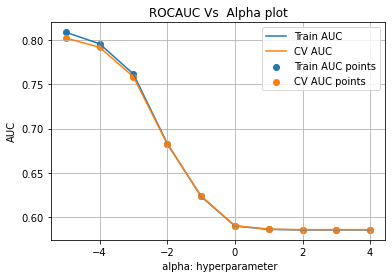

{'alpha': 1e-05}
0.8025020318123766
best alpha log value
-5.0


In [12]:
# Packages required
# some of the code taken from stack overflow
import math
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt


neigh = linear_model.SGDClassifier(loss='log',max_iter=5000,penalty='l2')

alphas=np.array([0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]) # Different lamda values
tuned_parameters = {'alpha' : alphas} # lamda values in a dictionary In SGDClassifier named as alpha


clf = GridSearchCV(neigh, tuned_parameters, cv=5, scoring='roc_auc',return_train_score='true') 
clf.fit(train_cleanedtext, outputtrain)

results = pd.DataFrame.from_dict(clf.cv_results_)#please check the output of cv_results_
#  gridsearchcv execution will understand. concepts required KFold cross validation
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']

cv_auc = results['mean_test_score'] 

k =  results['param_alpha']

alpha1=[]
for i in range(0,len(k),1):
   l=math.log10(k[i])
   alpha1.append(l)
alpha1.sort()
plt.plot(alpha1, train_auc, label='Train AUC')

plt.plot(alpha1, cv_auc, label='CV AUC')

plt.scatter(alpha1, train_auc, label='Train AUC points')
plt.scatter(alpha1, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel(" alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ROCAUC Vs  Alpha plot")
plt.grid()
plt.show()


print(clf.best_params_)
print(clf.best_score_)
print("best alpha log value")
a=math.log10(clf.best_params_.get('alpha'))
print(a)

# 1: use the hyper-parameter(lambda) to train the model & find function
# 2: use that function to find out the best threshold value(np.argmax(tpr*(1-fpr)) )
# 3: use that threshold to compute predicted value(y) & compute confusion matrix


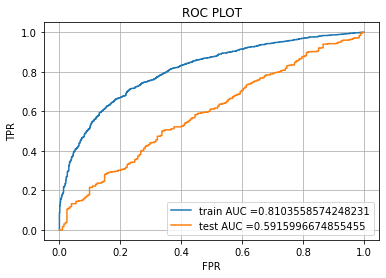

---------------------------------------------------
the maximum value of tpr*(1-fpr) 0.5477982894074849 for threshold 0.681
Train confusion matrix


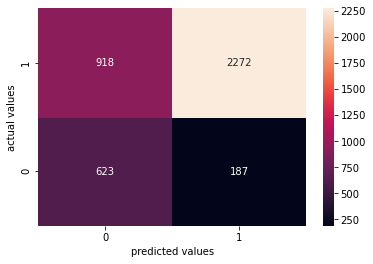

Test confusion matrix


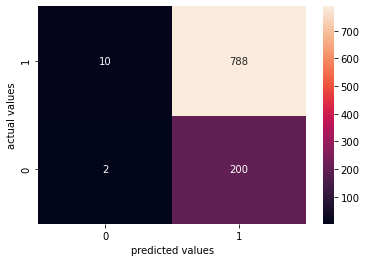

In [13]:

from sklearn.metrics import roc_curve, auc
import seaborn as sns

neigh = linear_model.SGDClassifier(loss='log',max_iter=5000,alpha=1e-05,penalty='l2')
neigh.fit(train_cleanedtext, outputtrain)



y_train_pred = neigh.predict_proba(train_cleanedtext)[:,1]    
y_test_pred = neigh.predict_proba(test_cleanedtext)[:,1]
#print(y_test_pred)
train_fpr, train_tpr, tr_thresholds = roc_curve(outputtrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(outputtest, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("---------------------------------------------------")


from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")

ax=sns.heatmap(confusion_matrix(outputtrain, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx=sns.heatmap(confusion_matrix(outputtest, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()